In [45]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import (classification_report, confusion_matrix, 
                            roc_auc_score, roc_curve, precision_recall_curve,
                            f1_score, accuracy_score)
import statsmodels
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import json
from pathlib import Path
import re

In [9]:
# =============================================================================
# LOAD ALL SUBJECTS' DATA
# =============================================================================
# Update these paths to your data directories
preprocessed_dir = Path('/Users/pranmodu/Projects/columbia/liinc/data/results/preprocessing')
raw_dir = Path('/Users/pranmodu/Projects/columbia/liinc/data/json')

# Get all preprocessed JSON files
preprocessed_files = list(preprocessed_dir.glob('preprocessing_*.json'))
print(f"Found {len(preprocessed_files)} preprocessed files")

# =============================================================================
# CHOOSE BASELINE METHOD
# =============================================================================
baseline_method = 't3_stable_pre_decision'  # or 't0_initial_fixation', 't1_post_stabilization', 't2_early_post_stimulus'

Found 10 preprocessed files


In [43]:
list(raw_dir.glob(f"*{subject_id.split('_')[-1]}.json"))

[PosixPath('/Users/pranmodu/Projects/columbia/liinc/data/json/Copy of 1005_1600_LCT_DESKTOP-U9TEJGM.json'),
 PosixPath('/Users/pranmodu/Projects/columbia/liinc/data/json/Copy of 0927_0930_LCT_DESKTOP-U9TEJGM.json'),
 PosixPath('/Users/pranmodu/Projects/columbia/liinc/data/json/Copy of 0928_1600_LCT_DESKTOP-U9TEJGM.json'),
 PosixPath('/Users/pranmodu/Projects/columbia/liinc/data/json/Copy of 0930_1700_LCT_DESKTOP-U9TEJGM.json')]

In [85]:
# =============================================================================
# EXTRACT FEATURES FOR ALL SUBJECTS
# =============================================================================
all_physiology_features = []
all_behavior_features = []
all_outcomes = []
all_subject_ids = []
all_trial_ids = []

for preprocessed_file in preprocessed_files:
    
    # Load preprocessed data
    with open(preprocessed_file, 'r') as f:
        preprocessed = json.load(f)
    
    subject_id = preprocessed['subject_id']
    print(f"\nProcessing subject: {subject_id}")
    
    # Find corresponding raw data file
    matches = list(raw_dir.glob(f"*{subject_id.split('_')[-1]}.json"))
    pattern = subject_id.replace("_", ".*")  # makes regex flexible for possible text in between
    match = next((f for f in matches if re.search(pattern, f.name)), None)
    if not match:
        print("No matching file found.")
        continue
    
    with open(match, 'r') as f:
        raw_data = json.load(f)
    
    subject_trial_count = 0
    
    for trial_id, trial_data in preprocessed['trial_data'].items():

        # Get the baseline-corrected pupil data for chosen method
        method_data = trial_data['methods'][baseline_method]
        
        if method_data['success'] != True:
            continue
        
        # Get raw trial data for behavioral features
        raw_trial = raw_data['trials'][int(trial_id)-1]
        
        # Skip trials that weren't submitted
        if not raw_trial['gamble details']['submitted']:
            continue
        
        # =============================================================================
        # PHYSIOLOGY FEATURES (PRE + POST SUBMIT)
        # =============================================================================

        # Split data into pre-submit and post-submit periods
        time_aligned = np.array(trial_data['time_relative_to_submit'])
        pupil_avg = np.array(method_data['pupil_avg_baselined'])
        pupil_L = np.array(method_data['pupil_L_baselined'])
        pupil_R = np.array(method_data['pupil_R_baselined'])

        # Remove NaN values
        valid_mask = ~np.isnan(pupil_avg)
        pupil_avg_clean = pupil_avg[valid_mask]
        pupil_L_clean = pupil_L[valid_mask]
        pupil_R_clean = pupil_R[valid_mask]
        time_clean = time_aligned[valid_mask]

        if len(pupil_avg_clean) < 20:
            continue

        # ============= PRE-SUBMIT DATA (for prediction) =============
        pre_submit_mask = time_clean <= 0
        pupil_pre = pupil_avg_clean[pre_submit_mask]
        pupil_L_pre = pupil_L_clean[pre_submit_mask]
        pupil_R_pre = pupil_R_clean[pre_submit_mask]
        time_pre = time_clean[pre_submit_mask]

        # Check minimum samples for pre-submit
        if len(pupil_pre) < 10:
            continue

        # Calculate derivatives for pre-submit
        pupil_velocity_pre = np.diff(pupil_pre) if len(pupil_pre) > 1 else np.array([0])
        pupil_acceleration_pre = np.diff(pupil_velocity_pre) if len(pupil_velocity_pre) > 1 else np.array([0])
        dilation_mask_pre = pupil_velocity_pre > 0 if len(pupil_velocity_pre) > 0 else np.array([False])

        # ============= POST-SUBMIT DATA (for outcome response) =============
        post_submit_mask = (time_clean > 0) & (time_clean <= 2.0)
        pupil_post = pupil_avg_clean[post_submit_mask]
        pupil_L_post = pupil_L_clean[post_submit_mask]
        pupil_R_post = pupil_R_clean[post_submit_mask]
        time_post = time_clean[post_submit_mask]

        # Calculate derivatives for post-submit (if enough samples)
        if len(pupil_post) > 1:
            pupil_velocity_post = np.diff(pupil_post)
            pupil_acceleration_post = np.diff(pupil_velocity_post) if len(pupil_velocity_post) > 1 else np.array([0])
            dilation_mask_post = pupil_velocity_post > 0 if len(pupil_velocity_post) > 0 else np.array([False])
        else:
            pupil_velocity_post = np.array([0])
            pupil_acceleration_post = np.array([0])
            dilation_mask_post = np.array([False])

        # =============================================================================
        # EXTRACT FEATURES FOR BOTH PERIODS
        # =============================================================================

        physiology_features = {
            # ==================== PRE-SUBMIT FEATURES ====================
            # Central tendency
            'pupil_mean_pre': np.mean(pupil_pre),
            'pupil_std_pre': np.std(pupil_pre),
            
            # Temporal dynamics
            'pupil_slope_pre': np.polyfit(time_pre, pupil_pre, 1)[0] if len(time_pre) > 1 else 0,
            'time_to_peak_pre': time_pre[np.argmax(pupil_pre)] - time_pre[0] if len(time_pre) > 0 else 0,
            
            # Change from start to end
            'pupil_change_pre': (np.mean(pupil_pre[-min(10, len(pupil_pre)):]) - 
                                np.mean(pupil_pre[:min(10, len(pupil_pre))])) if len(pupil_pre) >= 10 else 0,
            
            # Variability
            'pupil_cv_pre': np.std(pupil_pre) / np.abs(np.mean(pupil_pre)) if (len(pupil_pre) > 0 and np.mean(pupil_pre) != 0) else 0,
            
            # Velocity metrics
            'pupil_velocity_mean_pre': np.mean(np.abs(pupil_velocity_pre)) if len(pupil_velocity_pre) > 0 else 0,
            'pupil_max_dilation_rate_pre': np.max(pupil_velocity_pre) if len(pupil_velocity_pre) > 0 else 0,
            'pupil_max_constriction_rate_pre': np.abs(np.min(pupil_velocity_pre)) if len(pupil_velocity_pre) > 0 else 0,
            
            # Acceleration
            'pupil_acceleration_std_pre': np.std(pupil_acceleration_pre) if len(pupil_acceleration_pre) > 1 else 0,
            
            # Temporal patterns
            'pct_time_dilating_pre': np.mean(dilation_mask_pre) if len(dilation_mask_pre) > 0 else 0,
            'num_dilation_peaks_pre': np.sum(np.diff(np.sign(pupil_velocity_pre)) > 0) if len(pupil_velocity_pre) > 1 else 0,
            
            # Eye asymmetry
            'eye_asymmetry_pre': np.nanmean(np.abs(pupil_L_pre - pupil_R_pre)) if len(pupil_L_pre) > 0 else 0,
            'eye_asymmetry_std_pre': np.nanstd(pupil_L_pre - pupil_R_pre) if len(pupil_L_pre) > 1 else 0,
            
            # ==================== POST-SUBMIT FEATURES ====================
            # Central tendency
            'pupil_mean_post': np.mean(pupil_post) if len(pupil_post) > 0 else 0,
            'pupil_std_post': np.std(pupil_post) if len(pupil_post) > 1 else 0,
            
            # Temporal dynamics
            'pupil_slope_post': np.polyfit(time_post, pupil_post, 1)[0] if len(time_post) > 1 else 0,
            'time_to_peak_post': time_post[np.argmax(pupil_post)] - time_post[0] if len(time_post) > 0 else 0,
            
            # Variability
            'pupil_cv_post': np.std(pupil_post) / np.abs(np.mean(pupil_post)) if (len(pupil_post) > 0 and np.mean(pupil_post) != 0) else 0,
            
            # Velocity metrics
            'pupil_velocity_mean_post': np.mean(np.abs(pupil_velocity_post)) if len(pupil_velocity_post) > 0 else 0,
            'pupil_max_dilation_rate_post': np.max(pupil_velocity_post) if len(pupil_velocity_post) > 0 else 0,
            'pupil_max_constriction_rate_post': np.abs(np.min(pupil_velocity_post)) if len(pupil_velocity_post) > 0 else 0,
            
            # Temporal patterns
            'pct_time_dilating_post': np.mean(dilation_mask_post) if len(dilation_mask_post) > 0 else 0,
            'num_dilation_peaks_post': np.sum(np.diff(np.sign(pupil_velocity_post)) > 0) if len(pupil_velocity_post) > 1 else 0,
            
            # Eye asymmetry
            'eye_asymmetry_post': np.nanmean(np.abs(pupil_L_post - pupil_R_post)) if len(pupil_L_post) > 0 else 0,
            'eye_asymmetry_std_post': np.nanstd(pupil_L_post - pupil_R_post) if len(pupil_L_post) > 1 else 0,
            
            # ==================== TRANSITION FEATURES ====================
            # Compare pre vs post
            'pupil_mean_change_pre_to_post': (np.mean(pupil_post) - np.mean(pupil_pre)) if len(pupil_post) > 0 and len(pupil_pre) > 0 else 0,
            'pupil_slope_change_pre_to_post': ((np.polyfit(time_post, pupil_post, 1)[0] if len(time_post) > 1 else 0) - 
                                            (np.polyfit(time_pre, pupil_pre, 1)[0] if len(time_pre) > 1 else 0)),
            
            # ==================== BASELINE ====================
            'baseline_L': method_data['baseline_L'],
            'baseline_R': method_data['baseline_R'],
            'baseline_avg': (method_data['baseline_L'] + method_data['baseline_R']) / 2,
        }
        
        # =============================================================================
        # BEHAVIOR FEATURES (from raw trial data)
        # =============================================================================
        gamble_params = raw_trial['gamble details']['gamble parameters']
        lct = raw_trial['lct']
        
        # Extract timing information
        show_screen_time = None
        submit_time = None
        click_time = None
        
        for event in lct:
            if 'show screen' in event['event']:
                show_screen_time = event['time']
            elif 'gamble clicked' in event['event']:
                click_time = event['time']
            elif 'submit' in event['event']:
                submit_time = event['time']
        
        if show_screen_time is None or submit_time is None:
            continue
        
        # Calculate timing metrics (convert to seconds)
        reaction_time = (click_time - show_screen_time) / 1000 if click_time else np.nan
        decision_time = (submit_time - show_screen_time) / 1000

        # Calculate expected values
        invest_ev = (gamble_params['invest amount 1'] * gamble_params['invest probability 1'] + 
                    gamble_params['invest amount 2'] * gamble_params['invest probability 2'])
        keep_ev = gamble_params['keep amount']
        ev_difference = invest_ev - keep_ev

        # Calculate variance
        invest_variance = ((gamble_params['invest amount 1'] - invest_ev)**2 * gamble_params['invest probability 1'] +
                        (gamble_params['invest amount 2'] - invest_ev)**2 * gamble_params['invest probability 2'])
        
        # Choice information
        final_choice = raw_trial['gamble details']['choices'][-1]['choice'] if len(raw_trial['gamble details']['choices']) > 0 else None
        chose_invest = 1 if final_choice == 'INVEST' else 0
        
        behavior_features = {
            # TIMING - Independent information
            'reaction_time': reaction_time if not np.isnan(reaction_time) else decision_time,
            'decision_time': decision_time,
            
            # GAMBLE PARAMETERS 
            'ev_difference': ev_difference,  # Captures relative attractiveness
            
            # RISK - Independent from EV
            'invest_variance': invest_variance,  # OR use std: np.sqrt(invest_variance)
            
            # AMBIGUITY - Independent
            'ambiguity': gamble_params['ambiguity'],
            
            # CONDITION - Independent  
            'condition_social': 1 if gamble_params['condition'] == 'social' else 0,
            
            # NORMALIZED RISK METRIC - Independent combination
            'risk_premium': ev_difference / np.sqrt(invest_variance) if invest_variance > 0 else 0,
        }
                
        # =============================================================================
        # OUTCOME VARIABLE
        # =============================================================================
        outcome = chose_invest  # Predicting INVEST (1) vs KEEP (0)
        
        # Store everything
        all_physiology_features.append(physiology_features)
        all_behavior_features.append(behavior_features)
        all_outcomes.append(outcome)
        all_subject_ids.append(subject_id)
        all_trial_ids.append(f"{trial_id}_{subject_id}")
        
        subject_trial_count += 1
    
    print(f"  Extracted {subject_trial_count} valid trials")

# =============================================================================
# CREATE DATAFRAMES
# =============================================================================
physiology_df = pd.DataFrame(all_physiology_features)
physiology_df.insert(0, 'subject_id', all_subject_ids)
physiology_df.insert(1, 'trial_id', all_trial_ids)

behavior_df = pd.DataFrame(all_behavior_features)
behavior_df.insert(0, 'subject_id', all_subject_ids)
behavior_df.insert(1, 'trial_id', all_trial_ids)

outcomes = np.array(all_outcomes)
subjects = np.array(all_subject_ids)

print(f"\n{'='*80}")
print(f"DATA SUMMARY (ALL SUBJECTS)")
print(f"{'='*80}")
print(f"Total subjects: {len(np.unique(subjects))}")
print(f"Total valid trials: {len(outcomes)}")
print(f"Physiology features: {physiology_df.shape[1]}")
print(f"Behavior features: {behavior_df.shape[1]}")
print(f"\nOutcome distribution:")
print(f"  KEEP (0): {np.sum(outcomes == 0)} ({np.mean(outcomes == 0):.1%})")
print(f"  INVEST (1): {np.sum(outcomes == 1)} ({np.mean(outcomes == 1):.1%})")

# Per-subject breakdown
print(f"\nPer-subject trial counts:")
subject_counts = pd.DataFrame({'subject': subjects, 'outcome': outcomes})
print(subject_counts.groupby('subject')['outcome'].agg(['count', 'mean']))

# Check for missing values
print(f"\nMissing values in physiology features:")
missing_physio = physiology_df.isnull().sum()
if missing_physio.sum() > 0:
    print(missing_physio[missing_physio > 0])
else:
    print("None!")

print(f"\nMissing values in behavior features:")
missing_behavior = behavior_df.isnull().sum()
if missing_behavior.sum() > 0:
    print(missing_behavior[missing_behavior > 0])
else:
    print("None!")


Processing subject: 0928_1600_U9TEJGM
  Extracted 93 valid trials

Processing subject: 0930_1700_U9TEJGM
  Extracted 123 valid trials

Processing subject: 1005_1600_U9TEJGM
  Extracted 51 valid trials

Processing subject: 0930_1700_539136F
  Extracted 95 valid trials

Processing subject: 0928_1600_539136F
  Extracted 110 valid trials

Processing subject: 1005_1600_539136F
  Extracted 121 valid trials

Processing subject: 0928_1600_9M4VCHG
  Extracted 117 valid trials

Processing subject: 0930_1700_9M4VCHG
  Extracted 112 valid trials

Processing subject: 0927_0930_U9TEJGM
  Extracted 99 valid trials

Processing subject: 1005_1600_9M4VCHG
  Extracted 123 valid trials

DATA SUMMARY (ALL SUBJECTS)
Total subjects: 10
Total valid trials: 1044
Physiology features: 33
Behavior features: 9

Outcome distribution:
  KEEP (0): 356 (34.1%)
  INVEST (1): 688 (65.9%)

Per-subject trial counts:
                   count      mean
subject                           
0927_0930_U9TEJGM     99  0.373737
0

In [86]:
physiology_df

,subject_id,trial_id,pupil_mean_pre,pupil_std_pre,pupil_slope_pre,time_to_peak_pre,pupil_change_pre,pupil_cv_pre,pupil_velocity_mean_pre,pupil_max_dilation_rate_pre,...,pupil_max_constriction_rate_post,pct_time_dilating_post,num_dilation_peaks_post,eye_asymmetry_post,eye_asymmetry_std_post,pupil_mean_change_pre_to_post,pupil_slope_change_pre_to_post,baseline_L,baseline_R,baseline_avg
0,0928_1600_U9TEJGM,4_0928_1600_U9TEJGM,0.025747,0.600433,-0.887872,0.249962,-1.162754,23.320559,0.047701,0.159757,...,0.041880,0.571429,4,1.947865,0.799251,0.024053,1.727285,0.385186,-0.646653,-0.130734
1,0928_1600_U9TEJGM,9_0928_1600_U9TEJGM,0.447229,0.273984,-0.071215,1.199820,0.140531,0.612625,0.037372,0.132774,...,0.085567,0.512605,6,0.840462,0.961168,0.105395,0.735737,-0.401363,-0.434381,-0.417872
2,0928_1600_U9TEJGM,10_0928_1600_U9TEJGM,-0.133402,0.235444,-0.154442,0.283291,0.164866,1.764922,0.029469,0.105264,...,0.082252,0.546218,5,2.797592,0.772804,0.094350,0.511445,0.852446,-0.949945,-0.048750
3,0928_1600_U9TEJGM,13_0928_1600_U9TEJGM,0.112158,0.420877,-0.459861,0.000000,-1.264087,3.752537,0.041500,0.093582,...,0.099197,0.705882,5,0.728148,0.594755,0.681989,1.330580,-1.065998,-0.272744,-0.669371
4,0928_1600_U9TEJGM,14_0928_1600_U9TEJGM,0.473647,0.163630,0.021084,0.316619,-0.064944,0.345468,0.023148,0.078801,...,0.488948,0.588235,6,0.714150,0.869629,-0.104471,-0.081926,-0.761234,-0.474944,-0.618089
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1039,1005_1600_9M4VCHG,127_1005_1600_9M4VCHG,0.020989,0.085878,-0.073127,0.699983,0.064608,4.091614,0.009521,0.025306,...,0.028283,0.554622,4,0.130786,0.114521,0.361748,0.548191,-0.301158,-0.163690,-0.232424
1040,1005_1600_9M4VCHG,128_1005_1600_9M4VCHG,0.202468,0.364592,-0.595604,0.349991,-0.782873,1.800738,0.016513,0.038453,...,0.051750,0.781513,2,0.105787,0.160191,-0.062029,0.793070,-0.272404,-0.363283,-0.317844
1041,1005_1600_9M4VCHG,129_1005_1600_9M4VCHG,0.054047,0.290519,-0.402281,0.149996,-0.881716,5.375273,0.016987,0.023292,...,0.045766,0.655462,3,0.225155,0.121863,-0.080505,0.568160,-0.303054,-0.112461,-0.207758
1042,1005_1600_9M4VCHG,130_1005_1600_9M4VCHG,0.206058,0.390699,-0.577294,0.316659,-0.928542,1.896065,0.015856,0.026724,...,0.011397,0.605042,4,0.437918,1.252414,0.030301,1.053241,-0.282334,-0.341956,-0.312145


In [62]:
behavior_df

,reaction_time,decision_time,ev_difference,invest_variance,ambiguity,condition_social,risk_premium
0,0.003120,0.003809,-0.059,77.938419,0,0,-0.006683
1,0.002609,0.003631,0.827,14.735571,6,0,0.215438
2,0.003532,0.004365,0.586,32.854404,3,1,0.102235
3,0.002743,0.004208,0.172,57.335616,6,0,0.022715
4,0.001410,0.002254,0.669,25.313739,0,0,0.132968
...,...,...,...,...,...,...,...
1039,0.000877,0.001632,0.728,20.054016,3,0,0.162566
1040,0.002654,0.003543,0.178,67.289716,6,1,0.021699
1041,0.000899,0.001755,0.829,10.503459,0,0,0.255793
1042,0.001088,0.002166,0.812,7.011456,0,1,0.306656


In [63]:
from sklearn.impute import SimpleImputer

print(f"Before imputation: {physiology_df.isnull().sum().sum()} NaN values")

imputer = SimpleImputer(strategy='median')
physiology_df = pd.DataFrame(
    imputer.fit_transform(physiology_df),
    columns=physiology_df.columns,
    index=physiology_df.index
)

print(f"After imputation: {physiology_df.isnull().sum().sum()} NaN values")

Before imputation: 0 NaN values
After imputation: 0 NaN values



MULTICOLLINEARITY ANALYSIS - PHYSIOLOGY FEATURES

⚠️  Highly correlated feature pairs (|r| > 0.9):
None


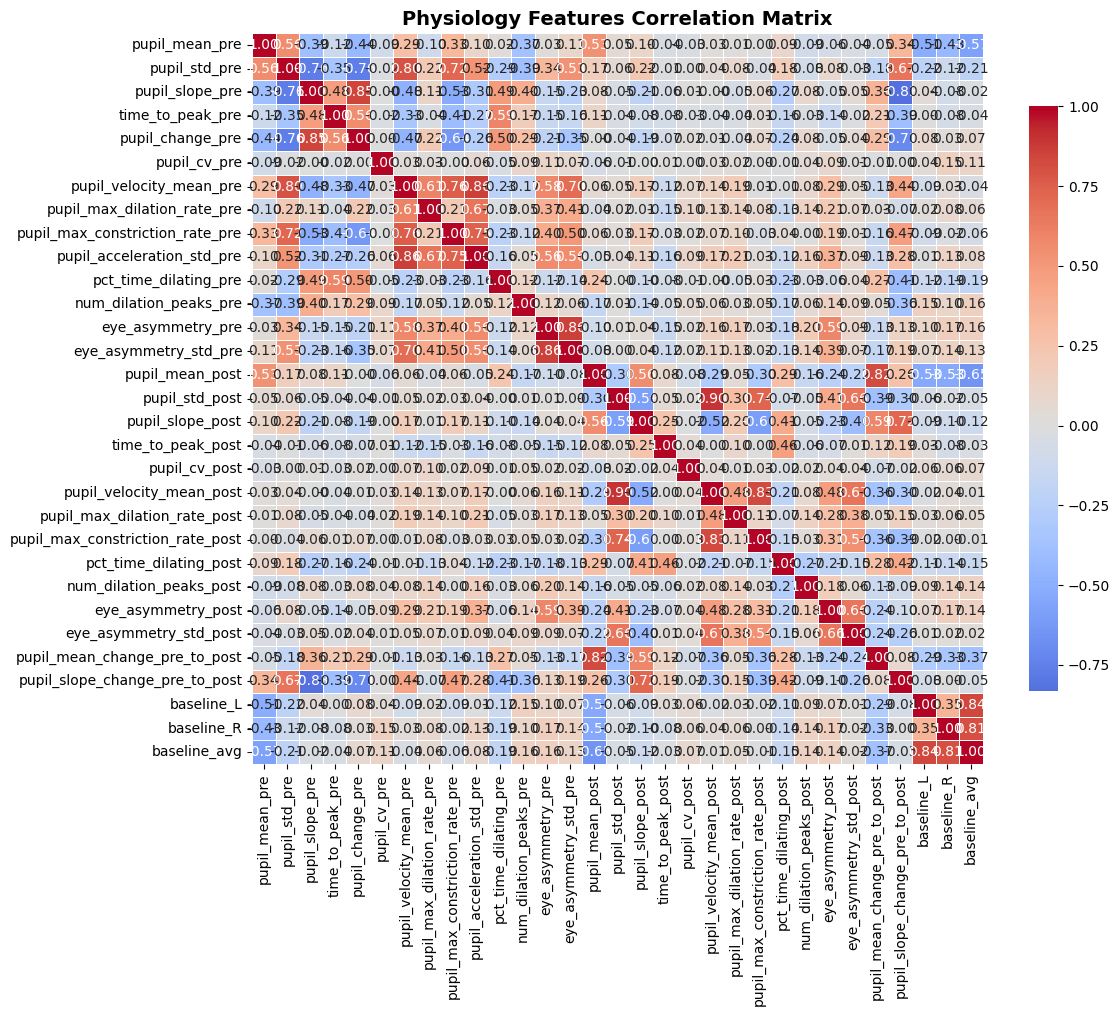

In [65]:
# =============================================================================
# CHECK MULTICOLLINEARITY IN PHYSIOLOGY FEATURES
# =============================================================================
print(f"\n{'='*80}")
print(f"MULTICOLLINEARITY ANALYSIS - PHYSIOLOGY FEATURES")
print(f"{'='*80}")

# Calculate correlation matrix
physiology_corr = physiology_df.corr()

# Find highly correlated pairs (>0.9)
high_corr_pairs = []
for i in range(len(physiology_corr.columns)):
    for j in range(i+1, len(physiology_corr.columns)):
        if abs(physiology_corr.iloc[i, j]) > 0.9:
            high_corr_pairs.append({
                'feature_1': physiology_corr.columns[i],
                'feature_2': physiology_corr.columns[j],
                'correlation': physiology_corr.iloc[i, j]
            })

print(f"\n⚠️  Highly correlated feature pairs (|r| > 0.9):")
if len(high_corr_pairs) == 0:
    print('None')
for pair in high_corr_pairs:
    print(f"  {pair['feature_1']} <-> {pair['feature_2']}: {pair['correlation']:.3f}")

# Visualize correlation matrix
fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(physiology_corr, annot=True, fmt='.2f', cmap='coolwarm', center=0,
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})
ax.set_title('Physiology Features Correlation Matrix', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Baseline Classification

## TASK 2: PHYSIOLOGY → OUTCOME (Direct)

In [72]:
# =============================================================================
# TASK 2: PHYSIOLOGY → OUTCOME (Direct)
# =============================================================================
print(f"\n{'='*80}")
print(f"TASK 2: PHYSIOLOGY → OUTCOME (Direct)")
print(f"{'='*80}")

# Prepare data
X_physio = physiology_df.values
y = outcomes

# Check class balance
print(f"\nClass balance check:")
print(f"  Minimum class size: {min(np.bincount(y))}")
print(f"  Class ratio: {np.mean(y):.3f}")

# Train-test split (stratified to maintain class balance)
X_train_physio, X_test_physio, y_train, y_test = train_test_split(
    X_physio, y, test_size=0.3, random_state=42, stratify=y
)

print(f"\nTraining samples: {len(y_train)} (KEEP: {np.sum(y_train==0)}, INVEST: {np.sum(y_train==1)})")
print(f"Test samples: {len(y_test)} (KEEP: {np.sum(y_test==0)}, INVEST: {np.sum(y_test==1)})")


TASK 2: PHYSIOLOGY → OUTCOME (Direct)

Class balance check:
  Minimum class size: 356
  Class ratio: 0.659

Training samples: 730 (KEEP: 249, INVEST: 481)
Test samples: 314 (KEEP: 107, INVEST: 207)


In [73]:
# Train Random Forest classifier
rf_physio = RandomForestClassifier(
    n_estimators=100, 
    random_state=42, 
    max_depth=5,
    min_samples_split=10,
    min_samples_leaf=5,
    class_weight='balanced'  # Handle class imbalance
)
rf_physio.fit(X_train_physio, y_train)

# Predictions
y_pred_physio = rf_physio.predict(X_test_physio)
y_prob_physio = rf_physio.predict_proba(X_test_physio)[:, 1]

# Evaluation
accuracy_physio = accuracy_score(y_test, y_pred_physio)
print(f"\nAccuracy: {accuracy_physio:.3f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_physio, target_names=['KEEP', 'INVEST']))


Accuracy: 0.643

Classification Report:
              precision    recall  f1-score   support

        KEEP       0.48      0.61      0.54       107
      INVEST       0.77      0.66      0.71       207

    accuracy                           0.64       314
   macro avg       0.62      0.63      0.62       314
weighted avg       0.67      0.64      0.65       314



In [74]:
# Cross-validation
cv_scores = cross_val_score(rf_physio, X_physio, y, cv=5, scoring='accuracy')
print(f"\n5-Fold Cross-Validation Accuracy: {cv_scores.mean():.3f} (+/- {cv_scores.std():.3f})")


5-Fold Cross-Validation Accuracy: 0.539 (+/- 0.060)



Top 10 Most Important Physiology Features:
                            feature  importance
2                   pupil_slope_pre    0.100199
27   pupil_slope_change_pre_to_post    0.091395
10            pct_time_dilating_pre    0.064064
4                  pupil_change_pre    0.062358
1                     pupil_std_pre    0.061507
3                  time_to_peak_pre    0.048776
5                      pupil_cv_pre    0.043668
16                 pupil_slope_post    0.036995
12                eye_asymmetry_pre    0.035173
8   pupil_max_constriction_rate_pre    0.031786


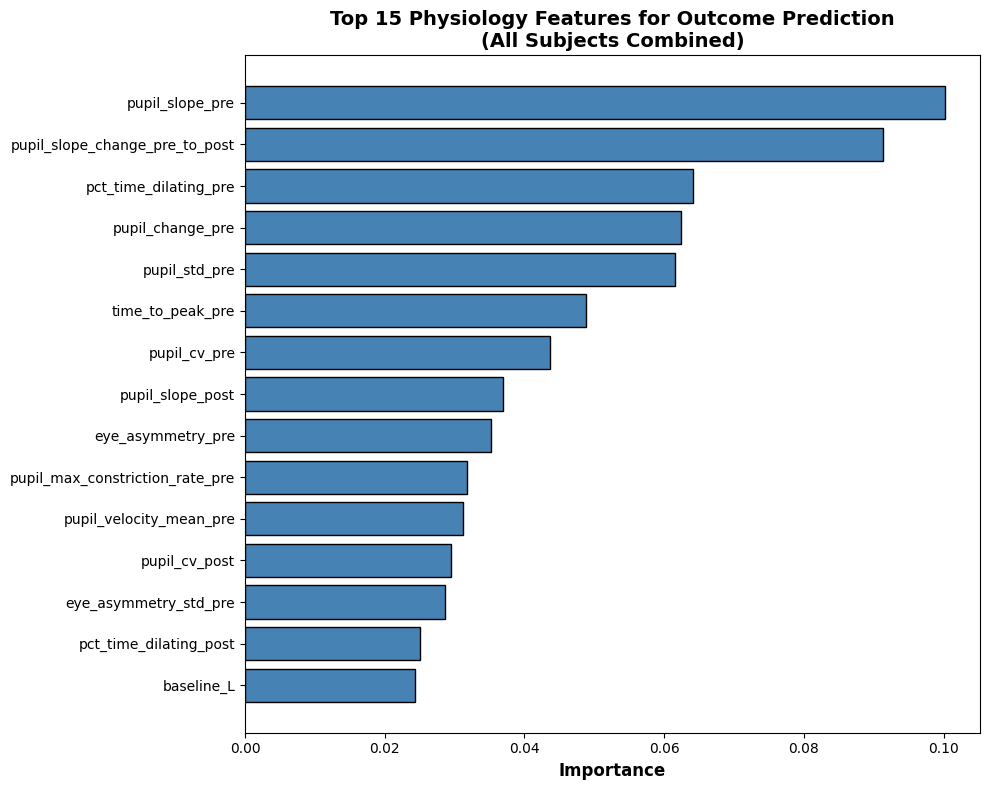

In [75]:
# Feature importance
feature_importance_physio = pd.DataFrame({
    'feature': physiology_df.columns,
    'importance': rf_physio.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 10 Most Important Physiology Features:")
print(feature_importance_physio.head(10))

# Plot feature importance
fig, ax = plt.subplots(figsize=(10, 8))
top_n = min(15, len(feature_importance_physio))
ax.barh(range(top_n), feature_importance_physio['importance'][:top_n], color='steelblue', edgecolor='black')
ax.set_yticks(range(top_n))
ax.set_yticklabels(feature_importance_physio['feature'][:top_n])
ax.set_xlabel('Importance', fontsize=12, fontweight='bold')
ax.set_title(f'Top {top_n} Physiology Features for Outcome Prediction\n(All Subjects Combined)', 
             fontsize=14, fontweight='bold')
ax.invert_yaxis()
plt.tight_layout()
plt.show()

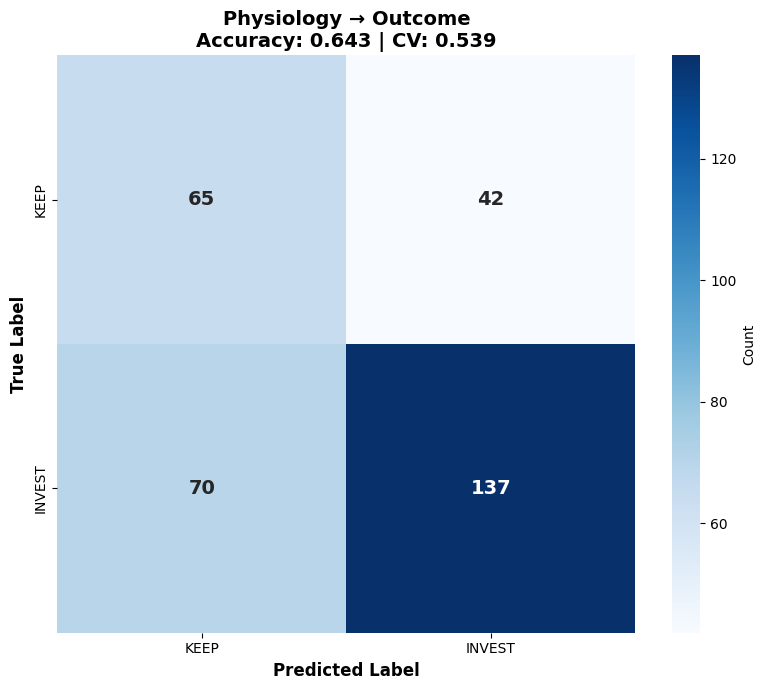

In [76]:
# Confusion matrix
cm_physio = confusion_matrix(y_test, y_pred_physio)
fig, ax = plt.subplots(figsize=(8, 7))
sns.heatmap(cm_physio, annot=True, fmt='d', cmap='Blues', ax=ax, cbar_kws={'label': 'Count'},
            xticklabels=['KEEP', 'INVEST'],
            yticklabels=['KEEP', 'INVEST'], 
            annot_kws={'size': 14, 'weight': 'bold'})
ax.set_title(f'Physiology → Outcome\nAccuracy: {accuracy_physio:.3f} | CV: {cv_scores.mean():.3f}', 
             fontsize=14, fontweight='bold')
ax.set_ylabel('True Label', fontsize=12, fontweight='bold')
ax.set_xlabel('Predicted Label', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

## TASK 3: BEHAVIOR → OUTCOME

In [77]:
# =============================================================================
# TASK 3: BEHAVIOR → OUTCOME
# =============================================================================
print(f"\n{'='*80}")
print(f"TASK 3: BEHAVIOR → OUTCOME")
print(f"{'='*80}")

# Prepare data
X_behavior = behavior_df.values
y = outcomes

# Train-test split (same random state for fair comparison)
X_train_behavior, X_test_behavior, y_train, y_test = train_test_split(
    X_behavior, y, test_size=0.3, random_state=42, stratify=y
)

print(f"\nTraining samples: {len(y_train)} (KEEP: {np.sum(y_train==0)}, INVEST: {np.sum(y_train==1)})")
print(f"Test samples: {len(y_test)} (KEEP: {np.sum(y_test==0)}, INVEST: {np.sum(y_test==1)})")


TASK 3: BEHAVIOR → OUTCOME

Training samples: 730 (KEEP: 249, INVEST: 481)
Test samples: 314 (KEEP: 107, INVEST: 207)


In [78]:
# Train Random Forest classifier
rf_behavior = RandomForestClassifier(
    n_estimators=100, 
    random_state=42, 
    max_depth=5,
    min_samples_split=10,
    min_samples_leaf=5,
    class_weight='balanced'
)
rf_behavior.fit(X_train_behavior, y_train)

# Predictions
y_pred_behavior = rf_behavior.predict(X_test_behavior)
y_prob_behavior = rf_behavior.predict_proba(X_test_behavior)[:, 1]

# Evaluation
accuracy_behavior = accuracy_score(y_test, y_pred_behavior)
print(f"\nAccuracy: {accuracy_behavior:.3f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_behavior, target_names=['KEEP', 'INVEST']))


Accuracy: 0.662

Classification Report:
              precision    recall  f1-score   support

        KEEP       0.50      0.64      0.57       107
      INVEST       0.79      0.67      0.72       207

    accuracy                           0.66       314
   macro avg       0.64      0.66      0.64       314
weighted avg       0.69      0.66      0.67       314



In [79]:
# Cross-validation
cv_scores_behavior = cross_val_score(rf_behavior, X_behavior, y, cv=5, scoring='accuracy')
print(f"\n5-Fold Cross-Validation Accuracy: {cv_scores_behavior.mean():.3f} (+/- {cv_scores_behavior.std():.3f})")


5-Fold Cross-Validation Accuracy: 0.688 (+/- 0.053)



Behavior Feature Importance:
            feature  importance
0     reaction_time    0.312137
1     decision_time    0.308657
4         ambiguity    0.205354
6      risk_premium    0.062794
2     ev_difference    0.053137
3   invest_variance    0.042580
5  condition_social    0.015341


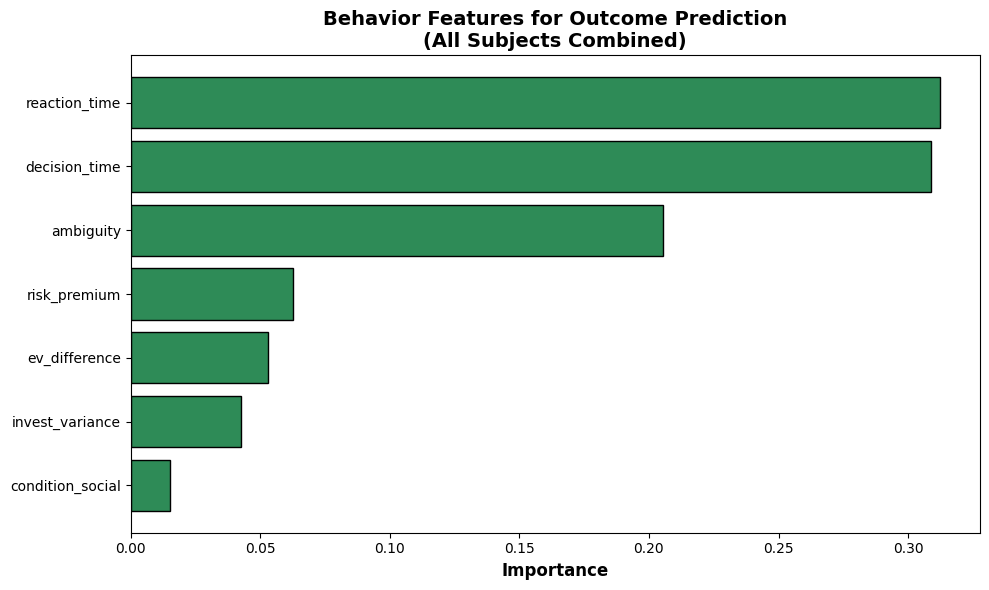

In [80]:
# Feature importance
feature_importance_behavior = pd.DataFrame({
    'feature': behavior_df.columns,
    'importance': rf_behavior.feature_importances_
}).sort_values('importance', ascending=False)

print("\nBehavior Feature Importance:")
print(feature_importance_behavior)

# Plot feature importance
fig, ax = plt.subplots(figsize=(10, 6))
ax.barh(range(len(feature_importance_behavior)), feature_importance_behavior['importance'], 
        color='seagreen', edgecolor='black')
ax.set_yticks(range(len(feature_importance_behavior)))
ax.set_yticklabels(feature_importance_behavior['feature'])
ax.set_xlabel('Importance', fontsize=12, fontweight='bold')
ax.set_title('Behavior Features for Outcome Prediction\n(All Subjects Combined)', 
             fontsize=14, fontweight='bold')
ax.invert_yaxis()
plt.tight_layout()
plt.show()

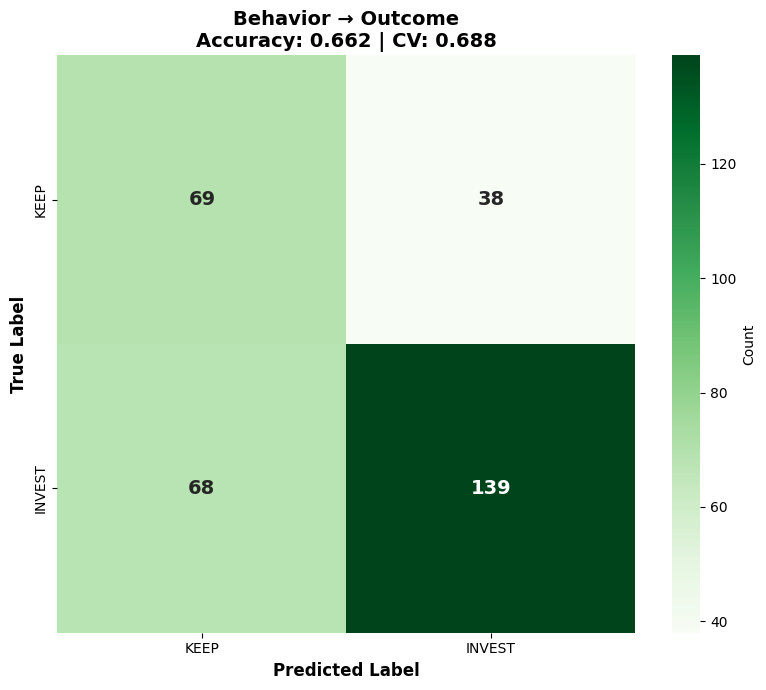

In [81]:
# Confusion matrix
cm_behavior = confusion_matrix(y_test, y_pred_behavior)
fig, ax = plt.subplots(figsize=(8, 7))
sns.heatmap(cm_behavior, annot=True, fmt='d', cmap='Greens', ax=ax, cbar_kws={'label': 'Count'},
            xticklabels=['KEEP', 'INVEST'],
            yticklabels=['KEEP', 'INVEST'],
            annot_kws={'size': 14, 'weight': 'bold'})
ax.set_title(f'Behavior → Outcome\nAccuracy: {accuracy_behavior:.3f} | CV: {cv_scores_behavior.mean():.3f}', 
             fontsize=14, fontweight='bold')
ax.set_ylabel('True Label', fontsize=12, fontweight='bold')
ax.set_xlabel('Predicted Label', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

# Pre predict post

# Post predict post